# ECON autoencoder loss analysis
This notebook aims to show the effect of the hyperparameters on the ECON model which could be hide to the user due to the approximation of the EMD metrics.

In [1]:
%reload_ext autoreload
%autoreload 2

# from common.metrics.gradient import Gradient
import torch
import torchinfo
import numpy as np
import pandas as pd
import pytorch_lightning as pl 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import warnings

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from q_autoencoder import AutoEncoder
from autoencoder_datamodule import AutoEncoderDataModule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from gradient import Gradient
from hessian import Hessian
from CKA import CKA
from neural_efficiency import NeuralEfficiency
from fisher import Fisher

# correlator4
DATA_PATH = '/data/tbaldi/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

/home/tbaldi/miniconda3/envs/loss_landscape/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### Utility methods

In [2]:
def get_model_index_and_relative_EMD(batch_size, learning_rate, precision, size, num_tests=3):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    EMDs = []
    min_emd = 1000
    min_emd_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'ECON_{precision}b/{size}/{size}_emd_{i}.txt'
        try:
            emd_file = open(file_path)
            emd_text = emd_file.read()
            emd = ast.literal_eval(emd_text)
            emd = emd[0]['AVG_EMD']
            EMDs.append(emd)
            if min_emd >= emd:
                min_emd = emd
                min_emd_index = i
            emd_file.close()
        except Exception as e:
            warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(EMDs) == 0:
        warnings.warn(f"Attention: There is no EMD value for the model: " \
                      f"bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}")
        #TODO: I may compute if the model is there
        return
    
    return mean(EMDs), min_emd_index


def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Reds',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(5, 4))

    # Create a heatmap using Seaborn
    sns.heatmap(values, cmap=cmap, annot=show_value, fmt=".2f", vmin=min_max[0], vmax=min_max[1])

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.colorbar(label=scale_label)

    # Display the plot
    plt.show()


def load_model(batch_size, learning_rate, precision, size):
    '''
    Method used to get the model and the relative EMD value
    '''
    emd, idx = get_model_index_and_relative_EMD(batch_size, learning_rate, precision, size)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/net_{idx}_best.pkl'
    
    # load the model
    model = AutoEncoder(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
        econ_type=size
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((1, 1, 8, 8)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, emd


def get_data_module(batch_size):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = AutoEncoderDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=4)
    
    # checek if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module



## EMD distance results

In [3]:
# search space
batch_sizes = [1024, 256, 128]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
size = 'small'

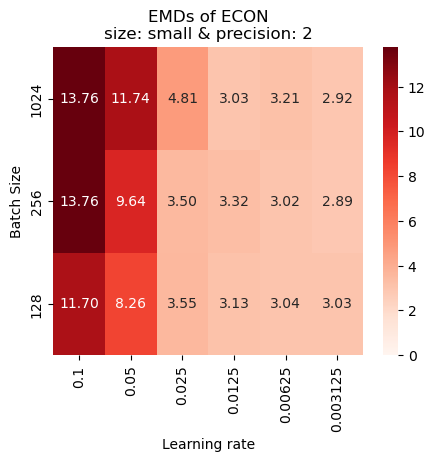

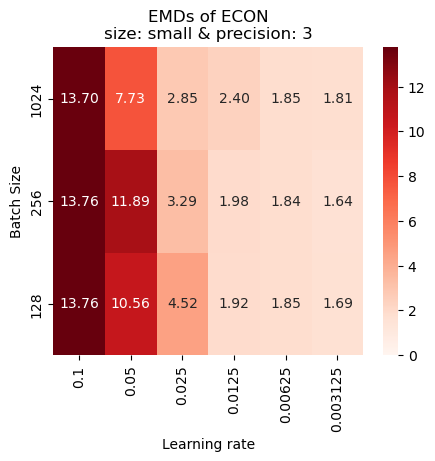

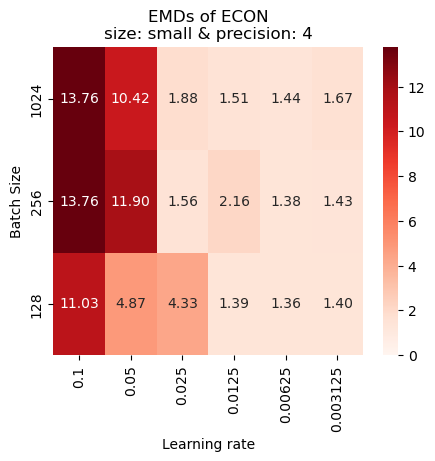

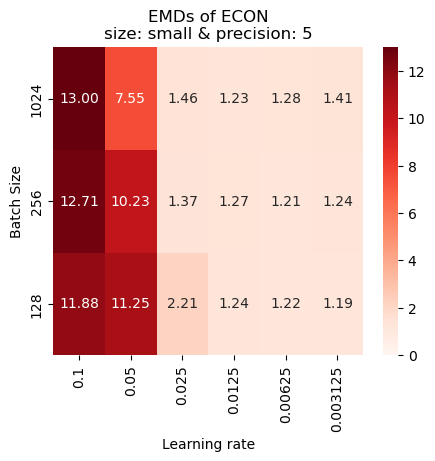

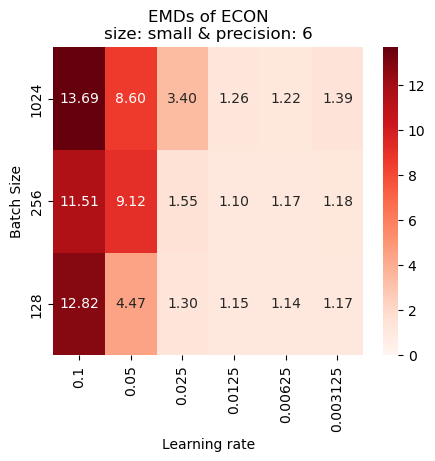

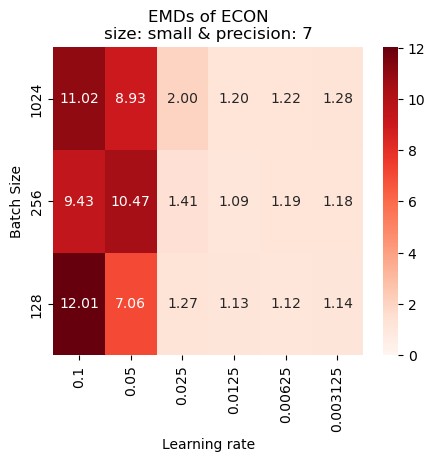

/tmp/ipykernel_89393/1376877292.py:22: UserWarning: Warning: /data/tbaldi/checkpoint/bs128_lr0.003125/ECON_8b/small/small_emd_1.txt not found!
  warnings.warn("Warning: " + file_path + " not found!")


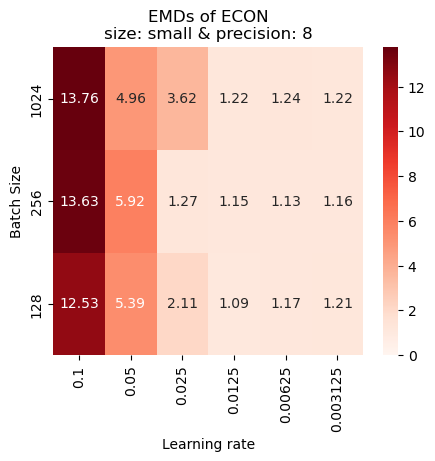

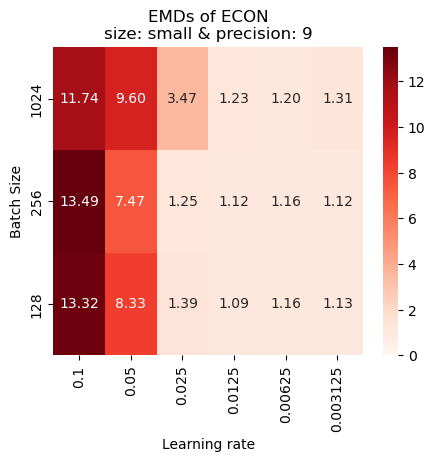

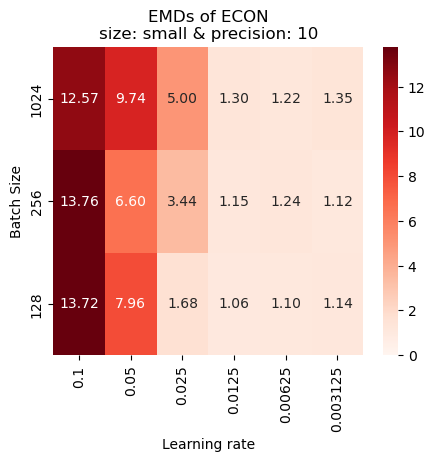

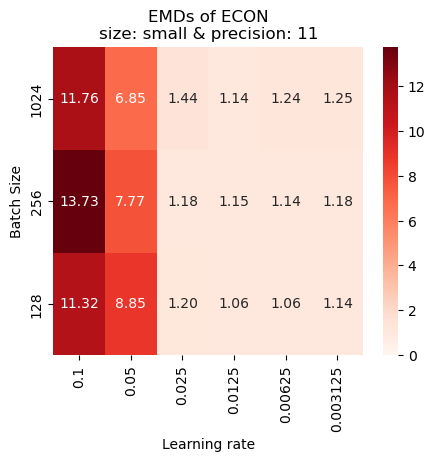

In [4]:
%matplotlib inline

#TODO: 3d heatmap

# plotting a heat map per layer
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            
            
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}', 
                    (0, max(EMD_matrix.max().max(), 3)),
                    'Learning rate',
                    'Batch Size',
                    'EMD')
    


We want to focus only with models with good performances so we cut out from the analysis the high learning rates.

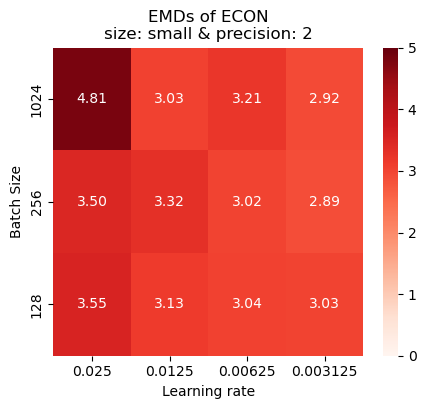

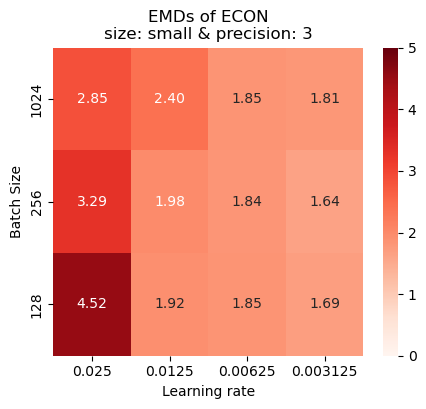

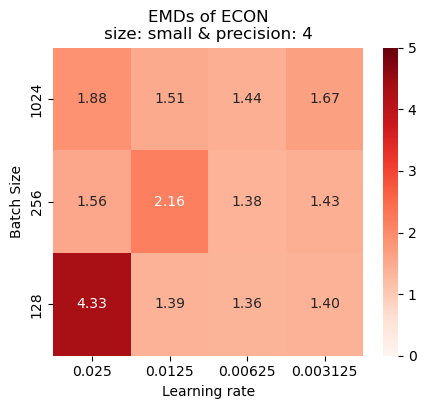

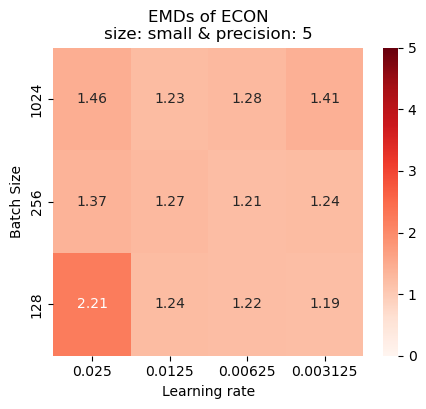

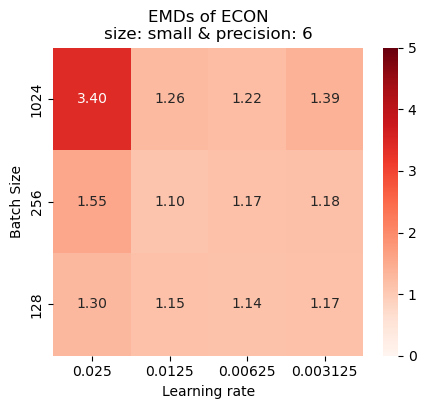

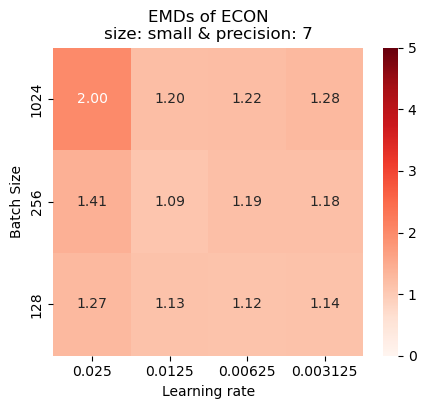

/tmp/ipykernel_89393/1376877292.py:22: UserWarning: Warning: /data/tbaldi/checkpoint/bs128_lr0.003125/ECON_8b/small/small_emd_1.txt not found!
  warnings.warn("Warning: " + file_path + " not found!")


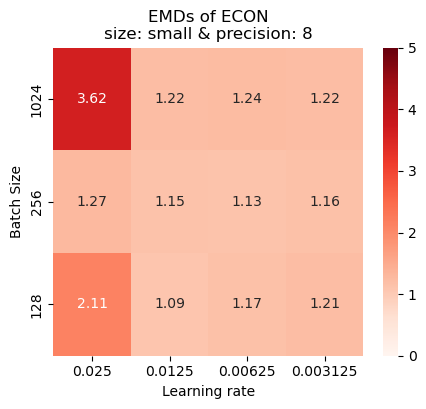

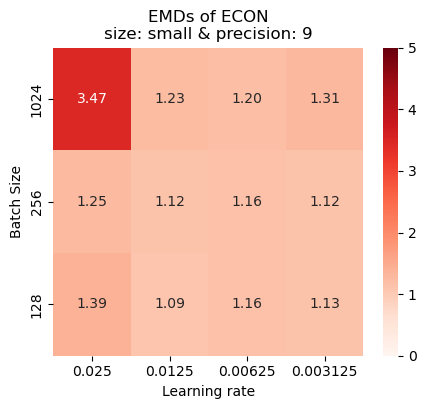

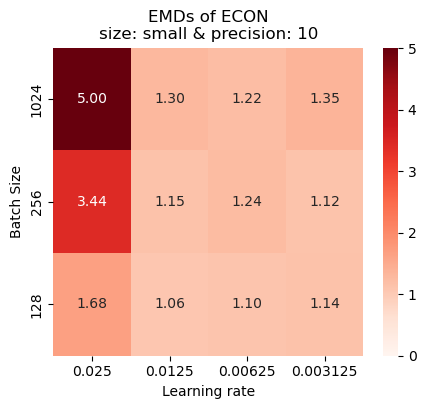

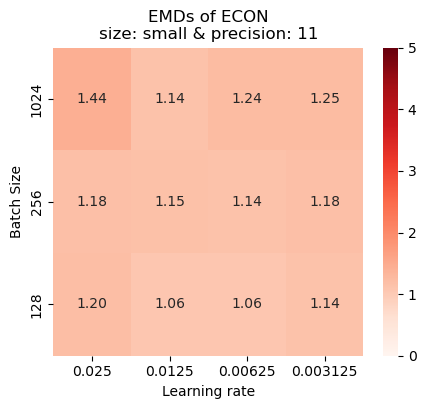

In [5]:
learning_rates = [0.025, 0.0125, 0.00625, 0.003125]
# plotting a heat map per layer
best_model = {}
worst_model = {}
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
    # store the matrix
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    # store best and worst model
    worst_model[p] = {
        'model': np.unravel_index(EMD_matrix.values.argmax(), EMD_matrix.shape),
        'EMD': EMD_matrix.values.max()
    }
    best_model[p] = {
        'model': np.unravel_index(EMD_matrix.values.argmin(), EMD_matrix.shape),
        'EMD': EMD_matrix.values.min()
    }
    # plot the matrix
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}', 
                    (0, max(EMD_matrix.max().max(), 5)),
                    'Learning rate',
                    'Batch Size',
                    'EMD')
    

## CKA similarity anlysis

In [6]:
def get_cka_per_model(batch_size, learning_rate, precision, size, activation_layers):
    model, _ = load_model(batch_size, learning_rate, precision, size)
    data_module = get_data_module(batch_size)
    return CKA(model, 
               data_module.test_dataloader(),
               activation_layers=activation_layers)

### Self model analysis
This metric can be used to carry analysis about the internal structure of the model, indeed the CKA similarity is used in XAI field to try to understand the path learned by the model. We are going to use that to see the difference between extrem cases, for both good and bad models.

Best vs Worst models:

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.294752e-08       5.525740e-01
encoder.enc_dense  5.525741e-01       2.561741e-10
average CKA: 0.5525740923219223


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


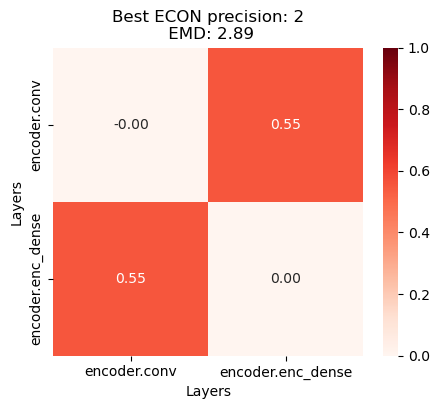

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.324461e-08       7.207860e-01
encoder.enc_dense  7.207860e-01       3.034639e-08
average CKA: 0.7207859668595267


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


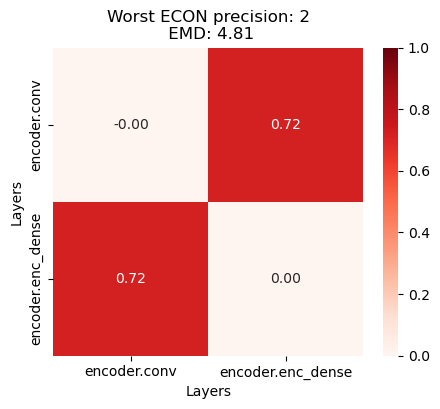

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.094825e-08       4.160384e-01
encoder.enc_dense  4.160382e-01      -2.634441e-08
average CKA: 0.41603828651322433


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


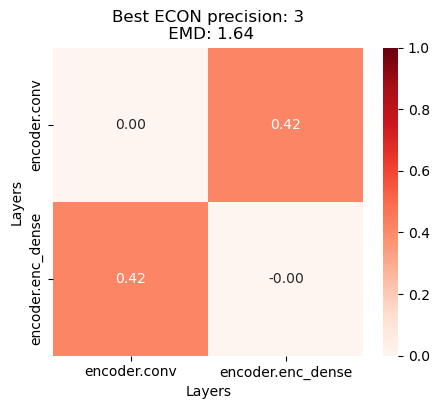

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.607872e-08       6.580700e-01
encoder.enc_dense  6.580700e-01       2.623753e-08
average CKA: 0.6580699524473228


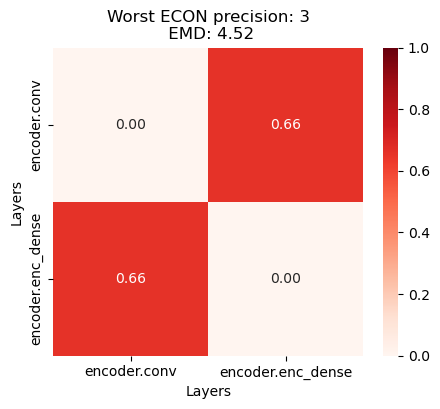

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.486198e-09       5.540241e-01
encoder.enc_dense  5.540241e-01      -3.279766e-08
average CKA: 0.5540241001682062


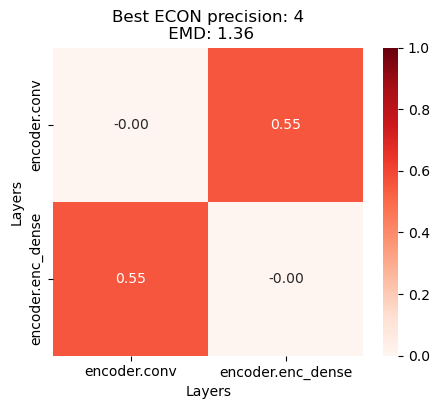

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.072169e-09       4.296472e-01
encoder.enc_dense  4.296472e-01      -4.399818e-08
average CKA: 0.42964718660937185


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


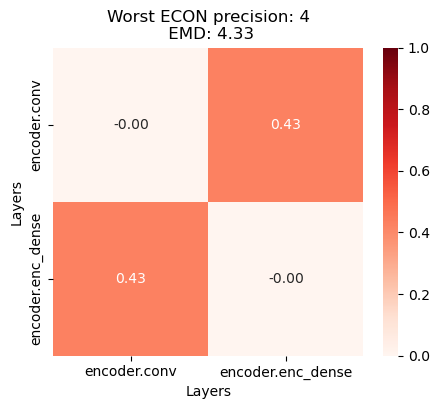

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.490589e-08       4.259074e-01
encoder.enc_dense  4.259074e-01       5.261519e-08
average CKA: 0.4259074031225246


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


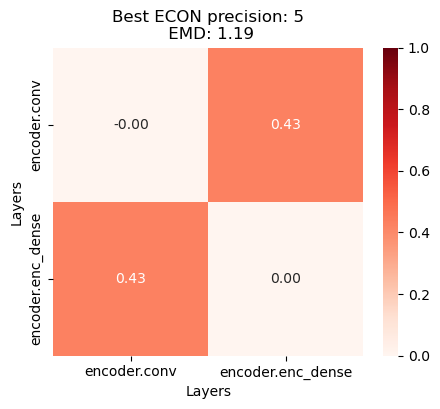

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.018010e-08       3.996326e-01
encoder.enc_dense  3.996326e-01       1.411454e-08
average CKA: 0.3996325522365275


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


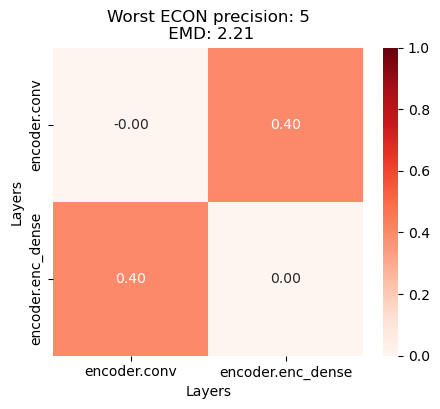

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.155792e-08       4.107679e-01
encoder.enc_dense  4.107679e-01       6.123789e-09
average CKA: 0.41076786202611826


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


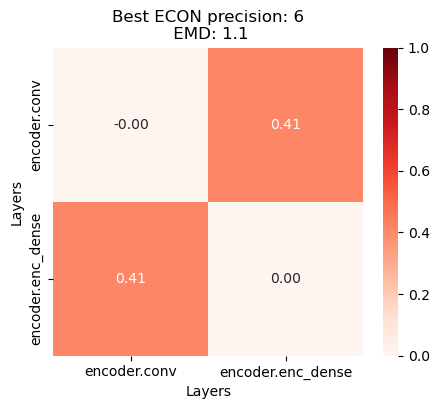

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.857607e-08       3.617248e-01
encoder.enc_dense  3.617248e-01       4.539313e-08
average CKA: 0.36172479294421267


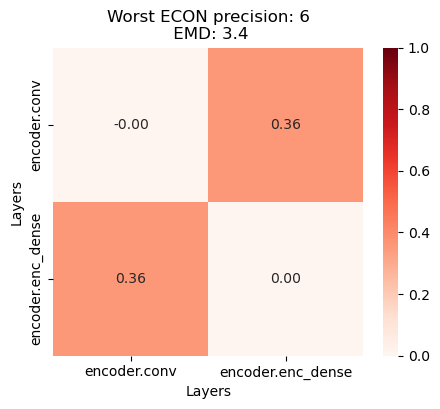

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.796040e-09       2.799537e-01
encoder.enc_dense  2.799537e-01      -1.957630e-08
average CKA: 0.2799536778917503


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


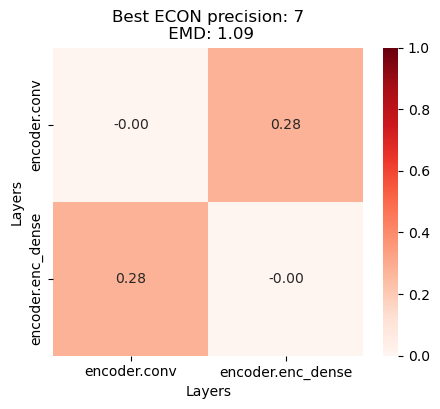

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.696056e-09       4.060213e-01
encoder.enc_dense  4.060213e-01       1.786778e-08
average CKA: 0.4060213432310813


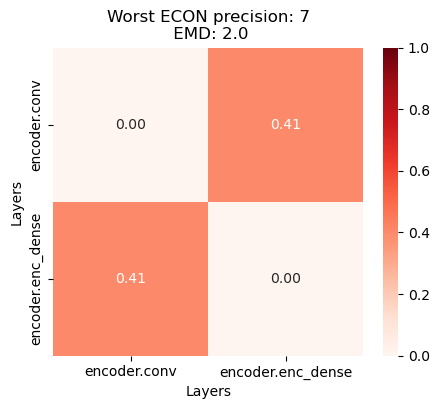

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.551052e-08       2.615618e-01
encoder.enc_dense  2.615618e-01      -2.288743e-08
average CKA: 0.2615618160630794


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


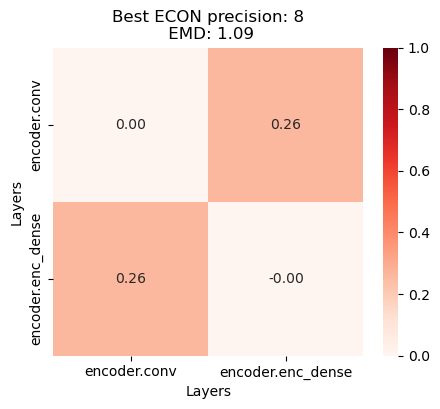

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -7.787063e-09       6.183906e-01
encoder.enc_dense  6.183904e-01       9.283074e-09
average CKA: 0.618390513351373


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


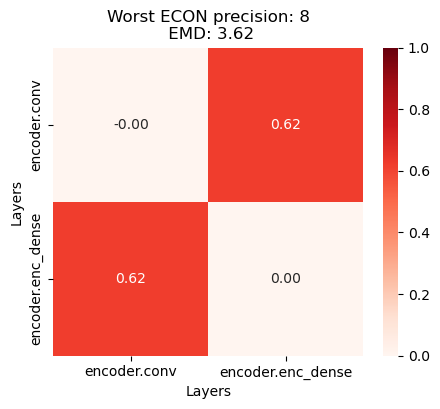

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -4.931579e-09       3.242666e-01
encoder.enc_dense  3.242666e-01       1.603733e-08
average CKA: 0.3242665522032079


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


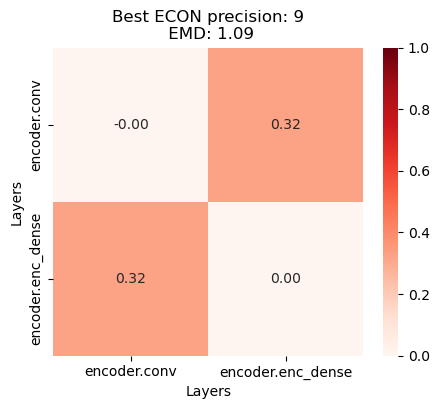

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.245042e-09       3.700702e-01
encoder.enc_dense  3.700701e-01       5.531486e-09
average CKA: 0.3700701326291443


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


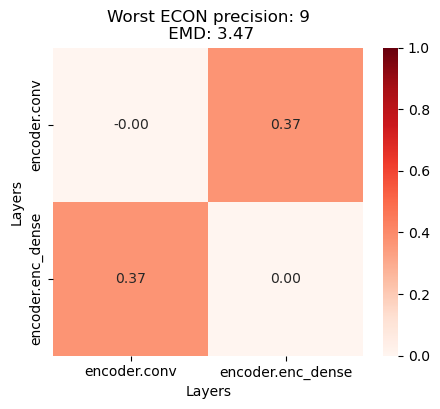

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.945483e-08       3.316095e-01
encoder.enc_dense  3.316095e-01      -2.238104e-08
average CKA: 0.3316095315398315


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


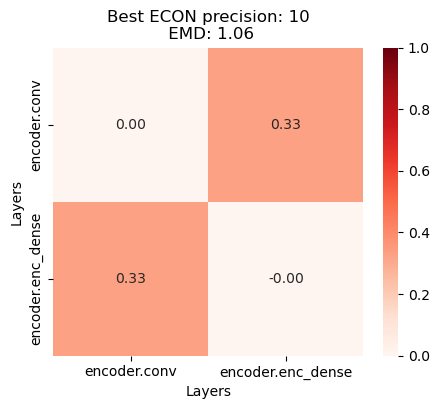

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.009372e-08       4.751311e-01
encoder.enc_dense  4.751310e-01       4.288926e-08
average CKA: 0.47513102443177285


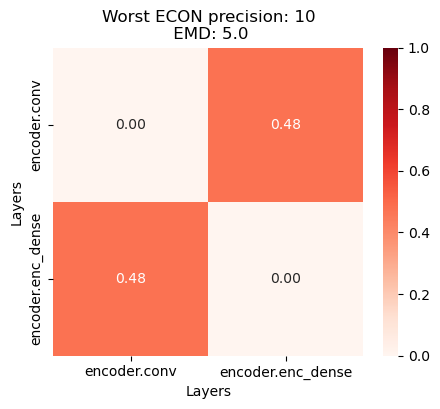

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.869605e-08       2.938158e-01
encoder.enc_dense  2.938158e-01       3.246958e-08
average CKA: 0.29381575562942563


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


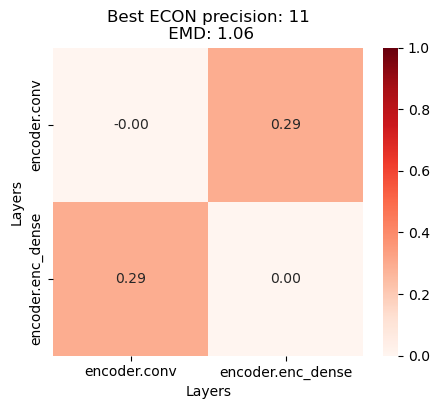

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.133764e-08       6.819790e-01
encoder.enc_dense  6.819788e-01       3.193647e-09
average CKA: 0.6819788862965351


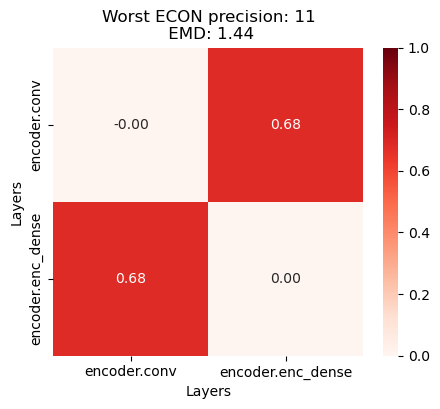

In [7]:
# plot the internal analysis for the best model for each precision
for p in best_model.keys():
    # best model
    cka = get_cka_per_model(batch_sizes[best_model[p]['model'][0]],
                            learning_rates[best_model[p]['model'][1]], 
                            p, 
                            size, 
                            ['encoder.conv', 'encoder.enc_dense'])
    result = cka.compute()
    plot_2d_heatmap(result['cka_dist'],
                    f'Best ECON precision: {p}\n EMD: {round(best_model[p]["EMD"], 2)}',
                    scale_label='CKA similarity')
    
    # worst model
    cka = get_cka_per_model(batch_sizes[worst_model[p]['model'][0]],
                            learning_rates[worst_model[p]['model'][1]], 
                            p, 
                            size, 
                            ['encoder.conv', 'encoder.enc_dense'])
    result = cka.compute()
    plot_2d_heatmap(result['cka_dist'],
                    f'Worst ECON precision: {p}\n EMD: {round(worst_model[p]["EMD"], 2)}',
                    scale_label='CKA similarity')

### Architecture difference

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.324461e-08       7.207860e-01
encoder.enc_dense  7.207860e-01       3.034639e-08
average CKA: 0.7207859668595267
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.225128e-08       6.208968e-01
encoder.enc_dense  6.208970e-01       1.471946e-08
average CKA: 0.6208968939214502
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       7.159748e-09       9.135277e-01
encoder.enc_dense  9.135274e-01      -1.826008e-08
average CKA: 0.9135275684265876
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.068037e-09       5.836843e-01
encoder.enc_dense  5.836852e-01      -3.067606e-08
average CKA: 0.5836847570777868
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -6.790350e-09       8.112239e-01
encoder.enc_dense  8.112240e-01       2.805706e-08
average CKA: 0.8112239743141467
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.294752e-08       5.257669e-01
encoder.enc_dense  5.257670e-01       1.611493e-08
average CKA: 0.5257669098981268
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.698173e-08       4.882370e-01
encoder.enc_dense  4.882370e-01       2.574299e-08
average CKA: 0.48823703499479165
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.294752e-08       5.525740e-01
encoder.enc_dense  5.525741e-01       2.561741e-10
average CKA: 0.5525740923219223
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")
/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:42: RuntimeWarning: invalid value encountered in true_divide
  B = B / np.linalg.norm(B, ord="fro")
/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:36: RuntimeWarning: invalid value encountered in true_divide
  A = A / np.linalg.norm(A, ord="fro")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.377545e-09                NaN
encoder.enc_dense           NaN                NaN
average CKA: nan
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.515935e-08       7.986414e-01
encoder.enc_dense  7.986414e-01       7.513175e-09
average CKA: 0.7986413998099327
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       7.741540e-09       6.514537e-01
encoder.enc_dense  6.514537e-01      -3.832429e-08
average CKA: 0.6514536833976603
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.117084e-08       6.785788e-01
encoder.enc_dense  6.785787e-01       9.666854e-09
average CKA: 0.6785787661214904


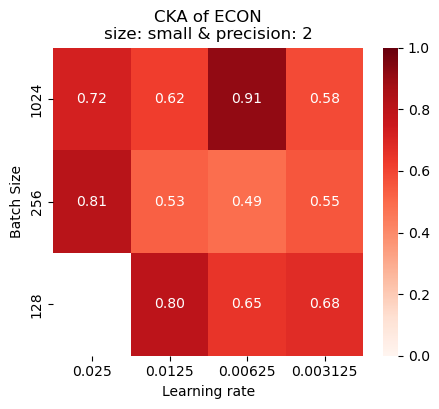

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.630404e-08       6.187401e-01
encoder.enc_dense  6.187403e-01      -3.215667e-08
average CKA: 0.6187402103483266
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.056687e-08       4.786875e-01
encoder.enc_dense  4.786874e-01      -4.714745e-08
average CKA: 0.47868745502381704
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -7.905820e-09       5.505358e-01
encoder.enc_dense  5.505359e-01       1.507686e-08
average CKA: 0.5505358496397057
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.024280e-08       4.956035e-01
encoder.enc_dense  4.956037e-01       2.895310e-08
average CKA: 0.4956035970954545
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       9.593297e-09       7.898804e-01
encoder.enc_dense  7.898804e-01      -4.878639e-08
average CKA: 0.7898804382946332
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.550996e-09       5.293000e-01
encoder.enc_dense  5.293000e-01       3.735315e-08
average CKA: 0.5293000042401141
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.554075e-08       4.440647e-01
encoder.enc_dense  4.440646e-01       1.046914e-08
average CKA: 0.44406467801195354
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.094825e-08       4.160384e-01
encoder.enc_dense  4.160382e-01      -2.634441e-08
average CKA: 0.41603828651322433
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.607872e-08       6.580700e-01
encoder.enc_dense  6.580700e-01       2.623753e-08
average CKA: 0.6580699524473228
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.506938e-08       4.300402e-01
encoder.enc_dense  4.300402e-01      -4.054929e-08
average CKA: 0.43004021447559393
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       4.243963e-09       6.135688e-01
encoder.enc_dense  6.135688e-01       2.746062e-08
average CKA: 0.6135688313892018
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.565589e-08       4.855509e-01
encoder.enc_dense  4.855509e-01      -8.621837e-09
average CKA: 0.485550890569281


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


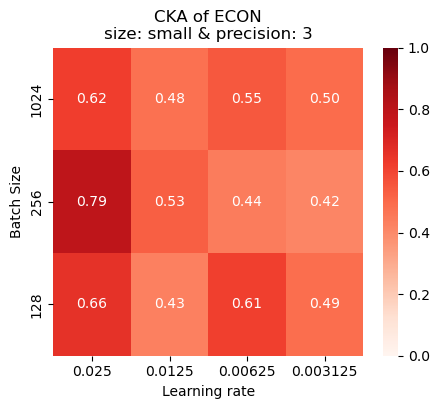

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.044532e-08       3.849261e-01
encoder.enc_dense  3.849261e-01      -4.670735e-08
average CKA: 0.38492606075933145
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.861928e-08       4.273876e-01
encoder.enc_dense  4.273878e-01      -1.922310e-08
average CKA: 0.42738769190766585
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       9.860875e-09       4.038384e-01
encoder.enc_dense  4.038381e-01      -3.464057e-09
average CKA: 0.4038382761780937
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.655881e-08       3.829824e-01
encoder.enc_dense  3.829824e-01      -5.034662e-08
average CKA: 0.3829823732573058
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.566412e-08       2.950195e-01
encoder.enc_dense  2.950195e-01      -4.201828e-09
average CKA: 0.2950195481130321
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -5.505480e-09       4.889863e-01
encoder.enc_dense  4.889863e-01       3.507234e-08
average CKA: 0.48898632973480594
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.838331e-08       4.038320e-01
encoder.enc_dense  4.038320e-01       1.973451e-08
average CKA: 0.4038320386447295
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.838331e-08       3.851122e-01
encoder.enc_dense  3.851122e-01       1.851011e-08
average CKA: 0.38511216562969175
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.072169e-09       4.296472e-01
encoder.enc_dense  4.296472e-01      -4.399818e-08
average CKA: 0.42964718660937185
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.491985e-08       5.795451e-01
encoder.enc_dense  5.795451e-01      -3.266996e-09
average CKA: 0.5795451092680566
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.486198e-09       5.540241e-01
encoder.enc_dense  5.540241e-01      -3.279766e-08
average CKA: 0.5540241001682062
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.120237e-09       3.614836e-01
encoder.enc_dense  3.614836e-01      -3.543545e-08
average CKA: 0.3614835962180817


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


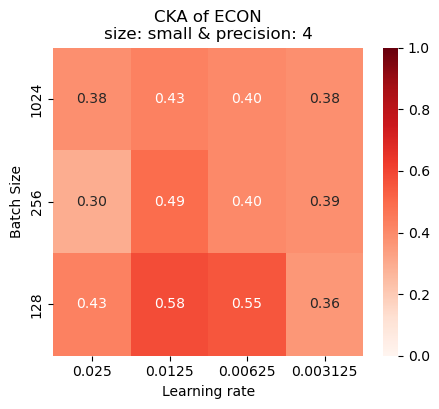

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.487828e-08       4.110929e-01
encoder.enc_dense  4.110929e-01      -4.220117e-08
average CKA: 0.41109285788292826
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.471430e-08       7.357001e-01
encoder.enc_dense  7.357000e-01      -1.385551e-08
average CKA: 0.7357000472530684
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       8.599422e-09       3.282354e-01
encoder.enc_dense  3.282351e-01      -1.598068e-08
average CKA: 0.32823528497451326
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -4.327414e-09       3.855687e-01
encoder.enc_dense  3.855688e-01      -7.249235e-10
average CKA: 0.3855687674273946
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.108953e-08       3.600603e-01
encoder.enc_dense  3.600603e-01       2.656777e-08
average CKA: 0.3600603053045912
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.009986e-08       3.835408e-01
encoder.enc_dense  3.835407e-01      -3.400403e-09
average CKA: 0.38354072185679805
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.434867e-08       3.658777e-01
encoder.enc_dense  3.658777e-01       1.223243e-08
average CKA: 0.3658776824038634
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.600287e-08       3.489412e-01
encoder.enc_dense  3.489412e-01       7.534499e-09
average CKA: 0.34894122074713163
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.018010e-08       3.996326e-01
encoder.enc_dense  3.996326e-01       1.411454e-08
average CKA: 0.3996325522365275
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -4.375832e-09       4.209890e-01
encoder.enc_dense  4.209889e-01       1.781424e-08
average CKA: 0.42098898259323836
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.121410e-08       3.780934e-01
encoder.enc_dense  3.780934e-01       1.622379e-08
average CKA: 0.37809340122075386
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.490589e-08       4.259074e-01
encoder.enc_dense  4.259074e-01       5.261519e-08
average CKA: 0.4259074031225246


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


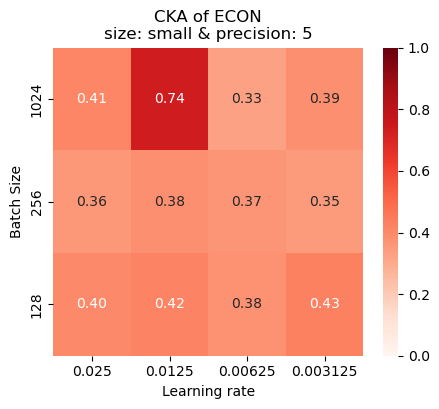

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.857607e-08       3.617248e-01
encoder.enc_dense  3.617248e-01       4.539313e-08
average CKA: 0.36172479294421267
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.751741e-08       4.228333e-01
encoder.enc_dense  4.228333e-01      -1.399670e-08
average CKA: 0.42283330541606334
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.742009e-08       3.436611e-01
encoder.enc_dense  3.436609e-01       7.613763e-09
average CKA: 0.3436609852168129
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -4.997879e-09       4.478466e-01
encoder.enc_dense  4.478466e-01      -3.666698e-08
average CKA: 0.4478465943448626
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.560167e-08       3.701621e-01
encoder.enc_dense  3.701621e-01       4.705139e-08
average CKA: 0.3701620685899545
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.155792e-08       4.107679e-01
encoder.enc_dense  4.107679e-01       6.123789e-09
average CKA: 0.41076786202611826
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.571630e-08       3.783637e-01
encoder.enc_dense  3.783638e-01      -1.447171e-08
average CKA: 0.37836375892865165
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.018953e-08       3.127685e-01
encoder.enc_dense  3.127686e-01      -1.140619e-08
average CKA: 0.31276856353837806
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.453247e-08       3.980303e-01
encoder.enc_dense  3.980305e-01      -3.533684e-08
average CKA: 0.39803041213962403
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.411706e-08       5.972693e-01
encoder.enc_dense  5.972692e-01      -1.430335e-08
average CKA: 0.5972692460425756
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.832515e-08       4.366776e-01
encoder.enc_dense  4.366776e-01       4.493272e-08
average CKA: 0.4366776131500528
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.026717e-08       3.451961e-01
encoder.enc_dense  3.451961e-01       1.616933e-08
average CKA: 0.34519609636274373


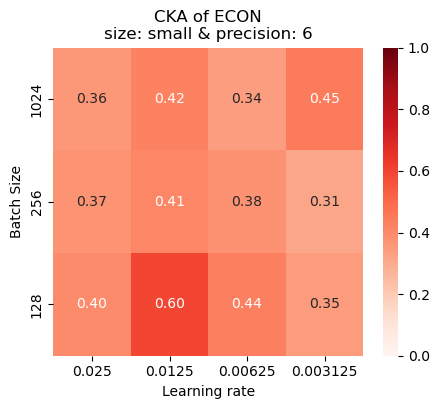

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.696056e-09       4.060213e-01
encoder.enc_dense  4.060213e-01       1.786778e-08
average CKA: 0.4060213432310813
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.053326e-08       3.343334e-01
encoder.enc_dense  3.343336e-01      -2.183156e-08
average CKA: 0.33433349231471704
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.502140e-08       4.334076e-01
encoder.enc_dense  4.334073e-01      -2.690357e-08
average CKA: 0.43340745569222155
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       4.769491e-09       4.728322e-01
encoder.enc_dense  4.728320e-01       1.132219e-08
average CKA: 0.4728321051629107
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.542000e-08       3.634317e-01
encoder.enc_dense  3.634318e-01       5.028292e-08
average CKA: 0.3634317703422089
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.796040e-09       2.799537e-01
encoder.enc_dense  2.799537e-01      -1.957630e-08
average CKA: 0.2799536778917503
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.337190e-08       3.586667e-01
encoder.enc_dense  3.586667e-01      -6.092014e-09
average CKA: 0.3586666622856778
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.196677e-08       3.343646e-01
encoder.enc_dense  3.343646e-01       1.860406e-08
average CKA: 0.3343645829548926
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.676915e-08       3.237419e-01
encoder.enc_dense  3.237419e-01      -1.137196e-08
average CKA: 0.32374193243793314
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.609966e-08       3.200793e-01
encoder.enc_dense  3.200792e-01      -1.221506e-08
average CKA: 0.32007922935762695
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.720398e-08       4.205415e-01
encoder.enc_dense  4.205415e-01      -4.464182e-10
average CKA: 0.4205414822544826
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.737164e-08       3.808168e-01
encoder.enc_dense  3.808169e-01      -4.730539e-08
average CKA: 0.3808168674314534


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


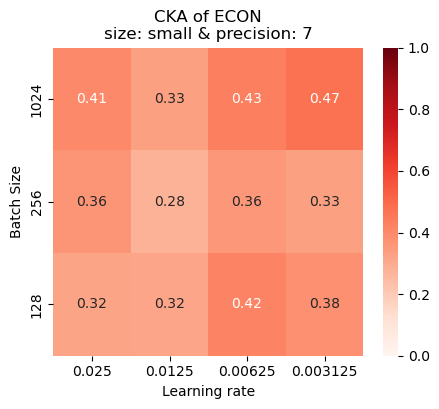

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -7.787063e-09       6.183906e-01
encoder.enc_dense  6.183904e-01       9.283074e-09
average CKA: 0.618390513351373
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.251003e-08       4.081560e-01
encoder.enc_dense  4.081562e-01       5.738388e-09
average CKA: 0.4081560926273377
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       4.023866e-08       3.951627e-01
encoder.enc_dense  3.951625e-01       2.777993e-08
average CKA: 0.3951626162042602
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.816538e-08       4.251120e-01
encoder.enc_dense  4.251117e-01       3.173839e-08
average CKA: 0.4251118756397582
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
enco

/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.238414e-08       3.637846e-01
encoder.enc_dense  3.637844e-01      -3.256657e-08
average CKA: 0.3637845030625031
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.028184e-08       4.388169e-01
encoder.enc_dense  4.388169e-01       2.659646e-08
average CKA: 0.43881688222201043
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.652435e-08       3.578788e-01
encoder.enc_dense  3.578787e-01       1.744639e-08
average CKA: 0.3578787732593817
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
enc

/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.551052e-08       2.615618e-01
encoder.enc_dense  2.615618e-01      -2.288743e-08
average CKA: 0.2615618160630794
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")
/tmp/ipykernel_89393/1376877292.py:22: UserWarning: Warning: /data/tbaldi/checkpoint/bs128_lr0.003125/ECON_8b/small/small_emd_1.txt not found!
  warnings.warn("Warning: " + file_path + " not found!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.360377e-08       4.046728e-01
encoder.enc_dense  4.046728e-01      -9.008805e-09
average CKA: 0.404672765175901
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -9.972260e-09       3.016821e-01
encoder.enc_dense  3.016821e-01       5.677281e-09
average CKA: 0.3016821201547786


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


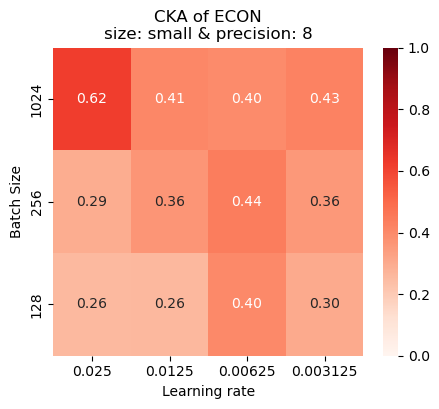

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.245042e-09       3.700702e-01
encoder.enc_dense  3.700701e-01       5.531486e-09
average CKA: 0.3700701326291443
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       5.316282e-09       3.653339e-01
encoder.enc_dense  3.653339e-01       2.578936e-08
average CKA: 0.36533391617428235
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.725691e-08       5.083151e-01
encoder.enc_dense  5.083149e-01       3.948463e-08
average CKA: 0.508315009498805
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
enco

/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       6.476976e-09       3.103054e-01
encoder.enc_dense  3.103054e-01      -2.575687e-08
average CKA: 0.31030543810412936
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.703621e-08       3.016634e-01
encoder.enc_dense  3.016633e-01      -7.290847e-09
average CKA: 0.30166333808533646
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.937593e-09       3.164515e-01
encoder.enc_dense  3.164515e-01       2.559616e-08
average CKA: 0.31645145562751364
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.332680e-08       2.523646e-01
encoder.enc_dense  2.523645e-01       4.363812e-09
average CKA: 0.25236454992885016
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.140881e-08       2.451249e-01
encoder.enc_dense  2.451248e-01      -4.126663e-09
average CKA: 0.24512485004457596
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -4.931579e-09       3.242666e-01
encoder.enc_dense  3.242666e-01       1.603733e-08
average CKA: 0.3242665522032079
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.258132e-08       3.449398e-01
encoder.enc_dense  3.449398e-01      -4.977359e-10
average CKA: 0.3449398162655565
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.328601e-08       3.948497e-01
encoder.enc_dense  3.948497e-01       1.675465e-08
average CKA: 0.39484967974914864


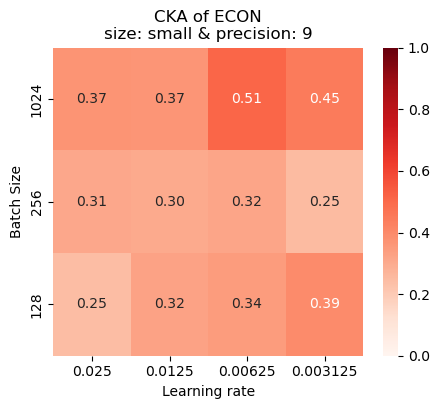

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.009372e-08       4.751311e-01
encoder.enc_dense  4.751310e-01       4.288926e-08
average CKA: 0.47513102443177285
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       4.835812e-09       4.007780e-01
encoder.enc_dense  4.007776e-01      -3.724413e-08
average CKA: 0.4007778119751787
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.828583e-08       5.282147e-01
encoder.enc_dense  5.282146e-01      -6.214014e-09
average CKA: 0.5282146467090025
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       5.516906e-09       4.706160e-01
encoder.enc_dense  4.706158e-01       6.802160e-09
average CKA: 0.47061591904731814
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.420020e-08       3.600361e-01
encoder.enc_dense  3.600361e-01      -2.970884e-08
average CKA: 0.3600361132639135
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.549162e-09       3.762085e-01
encoder.enc_dense  3.762085e-01       2.117342e-08
average CKA: 0.3762084701726921
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.857715e-08       2.818153e-01
encoder.enc_dense  2.818153e-01       1.239018e-08
average CKA: 0.2818152988306726
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.697682e-08       3.378311e-01
encoder.enc_dense  3.378308e-01      -8.493111e-10
average CKA: 0.33783095522655493
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       1.788522e-08       3.500797e-01
encoder.enc_dense  3.500797e-01       1.471455e-09
average CKA: 0.35007968214686735
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       2.945483e-08       3.316095e-01
encoder.enc_dense  3.316095e-01      -2.238104e-08
average CKA: 0.3316095315398315
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       6.582682e-09       3.587608e-01
encoder.enc_dense  3.587608e-01       2.094167e-09
average CKA: 0.3587607581045904
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.593456e-09       3.616602e-01
encoder.enc_dense  3.616602e-01       2.122815e-08
average CKA: 0.3616601710083196


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


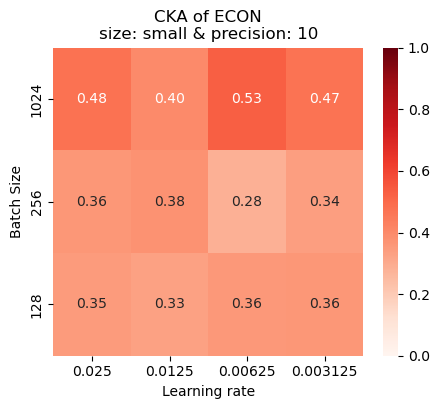

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.133764e-08       6.819790e-01
encoder.enc_dense  6.819788e-01       3.193647e-09
average CKA: 0.6819788862965351
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -2.561768e-08       4.430142e-01
encoder.enc_dense  4.430144e-01       2.442307e-08
average CKA: 0.44301430902261
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.763902e-08       4.970268e-01
encoder.enc_dense  4.970265e-01       6.755564e-09
average CKA: 0.49702663269285496
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       8.712996e-09       4.769195e-01
encoder.enc_dense  4.769195e-01       8.507436e-09
average CKA: 0.4769195358260804
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.644710e-08       2.618459e-01
encoder.enc_dense  2.618459e-01       3.037746e-08
average CKA: 0.26184591613376007
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.716038e-08       4.761643e-01
encoder.enc_dense  4.761643e-01       4.935274e-08
average CKA: 0.4761643248068602
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       9.848614e-09       2.513538e-01
encoder.enc_dense  2.513538e-01      -5.585438e-09
average CKA: 0.2513538140603079
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.010503e-08       2.964285e-01
encoder.enc_dense  2.964285e-01      -1.264721e-09
average CKA: 0.29642854733203816
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.746390e-09       3.397164e-01
encoder.enc_dense  3.397164e-01       2.109161e-08
average CKA: 0.339716428268229
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -3.869605e-08       2.938158e-01
encoder.enc_dense  2.938158e-01       3.246958e-08
average CKA: 0.29381575562942563
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv      -1.624812e-08       5.397034e-01
encoder.enc_dense  5.397035e-01      -3.990900e-09
average CKA: 0.5397034049575327
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.628897e-08       4.058960e-01
encoder.enc_dense  4.058962e-01      -5.532504e-08
average CKA: 0.40589608652043035


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


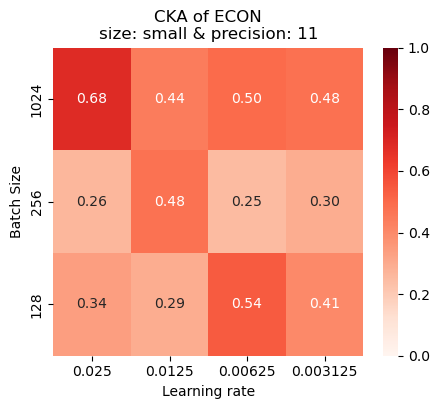

In [8]:
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            cka = get_cka_per_model(bs,
                                    lr, 
                                    p, 
                                    size, 
                                    ['encoder.conv', 'encoder.enc_dense'])
            result = cka.compute()
            EMD_matrix[x, y] = result['avg_cka']
    # store the matrix
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    # plot the matrix
    plot_2d_heatmap(EMD_matrix, 
                    f'CKA of ECON\nsize: {size} & precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'AVG CKA')

## Compare different architecture
Let's try to compare different models one against the other

In [ ]:
def 

## Compare the real EMD without the flags of the empty matrix
During the studies of the loss landscape, we discover a strange case in the test of the ECON model. The Econ model is an autoencoder used to compress the information coming from signals that are encoded in a sort of matrix. To evaluate the model we should use the EMD but it is not differentiable, so it is used only as test and the training and evaluation of the model is done with an approximate EMD loss function called Telescope.

Looking at the models with big batch sizes (ex. 512 or 1024) we achieved negative EMD values during the test of the model, but it should not be possible (EMD >= 0). Looking at the implementation of the model we found in the computation of the real EMD thi flag, where if the output of the Encoder is zero set the emd as -0.5 which bias the final average EMD of the model, which in most of the case is actually really high.

<div style="text-align:center">
    <img src="images/EMD_flag.png"></img>
</div>



In [10]:
def print_old_EMD(size, precision, bs, lr):
    print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
    for exp in range(1, 3):
        file_path = base_path + f'bs{bs}_lr{lr}/ECON_{precision}b/{size}/{size}_emd_{exp}.txt'
        try:
            with open(file_path, 'r') as file:
                content = file.read()
                print("AVG EMD: ", content)

        except Exception as e:
            continue


for lr in learning_rate:              
    print_old_EMD('small', 8, 1024, lr)

NameError: name 'learning_rate' is not defined

In [ ]:
trainer = pl.Trainer(
        max_epochs=5,
        accelerator="auto",
        devices=1
    )

def compute_real_EMD(size, precision, bs, lr):
    # load the model 
    model = load_model(base_path, bs, lr, precision, size)
    # get the data loader
    data_module = get_data_module(bs)
    _, val_sum = data_module.get_val_max_and_sum()
    model.set_val_sum(val_sum)
    data_module.setup("test")
    avg_emd = trainer.test(model, dataloaders=data_module.test_dataloader())
    print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
    print("AVG EMD: ", avg_emd)
    


compute_real_EMD('small', 8, 1024, 0.1)
print_old_EMD('small', 8, 1024, 0.1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)
Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 341/341 [02:08<00:00,  2.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            13.577227592468262
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.1 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 13.577227592468262}]
BATCH SIZE: 1024 - LEARNING RATE 0.1 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': -0.19799108803272247}]
AVG EMD:  [{'AVG_EMD': -0.5}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.05)
print_old_EMD('small', 8, 1024, 0.05)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [02:26<00:00,  2.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD             9.190462112426758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.05 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 9.190462112426758}]
BATCH SIZE: 1024 - LEARNING RATE 0.05 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 6.228666305541992}]
AVG EMD:  [{'AVG_EMD': 7.037817478179932}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.0125)
print_old_EMD('small', 8, 1024, 0.0125)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:28<00:00,  1.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.1153733730316162
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.0125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.1153733730316162}]
BATCH SIZE: 1024 - LEARNING RATE 0.0125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.1153912544250488}]
AVG EMD:  [{'AVG_EMD': 1.1363208293914795}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.00625)
print_old_EMD('small', 8, 1024, 0.00625)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:29<00:00,  1.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2486552000045776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.00625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2486552000045776}]
BATCH SIZE: 1024 - LEARNING RATE 0.00625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2486635446548462}]
AVG EMD:  [{'AVG_EMD': 1.254514455795288}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.003125)
print_old_EMD('small', 8, 1024, 0.003125)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:25<00:00,  1.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2884447574615479
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.003125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2884447574615479}]
BATCH SIZE: 1024 - LEARNING RATE 0.003125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2883154153823853}]
AVG EMD:  [{'AVG_EMD': 1.318579077720642}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.0015625)
print_old_EMD('small', 8, 1024, 0.0015625)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:31<00:00,  1.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2459907531738281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.0015625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2459907531738281}]
BATCH SIZE: 1024 - LEARNING RATE 0.0015625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2461320161819458}]
AVG EMD:  [{'AVG_EMD': 1.3005080223083496}]


As we can see from those results, negative values of EMD corresponds to really high values of EMD. I assume that when the model have to deal with large batch size and learning rates it has to process really big and sparse matrix which it just compress as Zero-matrices ignoring all the signals with low intensity. This could not be a problem since we are aware of it, especially because this event is not detected by the telescope loss function which returns good value of EMD. 